In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# External packages
import os
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import normaltest

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import split_path_at, get_data_root
from plotters import harmonize_axes_limits

# Figures dictionary
figs = {}

### Load dataset-aggregated data of response state dependency across lines

In [3]:
# Data directory
datadir = split_path_at(get_data_root(), 'raw')[0]

# Lines to compare
lines = ['line3', 'sst']

# Initialize empty data container
statdepdata = []

def load_state_dep_data(line):
    ''' Lod state dependence data from a line and return as a dataframe '''
    # Determine input file path
    fpath = os.path.join(datadir, f'statedep_data_{line}.csv')
    # Load data
    df = pd.read_csv(fpath)
    # Construct and sort multi-index
    df.set_index(['kind', Label.DATASET, Label.ISPTA], inplace=True)
    # df.set_index(Label.DATASET, inplace=True)
    # df.set_index(Label.ISPTA, append=True, inplace=True)
    df.sort_index(inplace=True)
    # Return
    return df

# Load data
statdepdata = pd.concat(dict(zip(
    lines, list(map(load_state_dep_data, lines)))), names=['line'], axis=0)

# Display
statdepdata

R
line  kind     dataset                 I_SPTA (W/cm2)          
line3 original 20190704_mouse2_region1 0.00           -0.592156
                                       0.04           -0.579223
                                       0.15           -0.655362
                                       0.20           -0.526026
                                       0.62           -0.640729
...                                                         ...
sst   shuffled 20190808_mouse8_region1 7.91           -0.683756
                                       9.89           -0.682951
                                       11.87          -0.738689
                                       13.85          -0.747742
                                       15.83          -0.709548

[990 rows x 1 columns]

### Plot and compare correlation coefficients trends across lines

 2023/10/12 18:59:26: plotting results vs ISPTA...
 2023/10/12 18:59:26: testing normality of distributions...


pval  normal
line  kind                      
line3 original  0.007648   False
      shuffled  0.209077    True
sst   original  0.000178   False
      shuffled  0.000290   False

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

shuffled_line3 vs. shuffled_sst: Mann-Whitney-Wilcoxon test two-sided, P_val:1.409e-26 U_stat=1.290e+04
original_line3 vs. original_sst: Mann-Whitney-Wilcoxon test two-sided, P_val:2.979e-10 U_stat=1.974e+04
original_line3 vs. shuffled_line3: Mann-Whitney-Wilcoxon test two-sided, P_val:2.873e-18 U_stat=6.079e+04
original_sst vs. shuffled_sst: Mann-Whitney-Wilcoxon test two-sided, P_val:1.441e-14 U_stat=2.943e+04


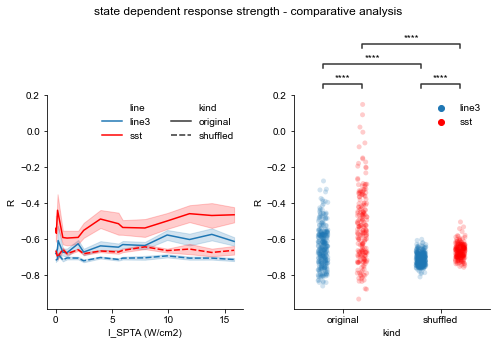

In [6]:
# Create figure and axes
figs['corrcoeff comparison'], axes = plt.subplots(1, 2, figsize=(7, 5))
for ax in axes:
    sns.despine(ax=ax)

# Plot correlation coefficient distributions vs ISPTA
logger.info('plotting results vs ISPTA...')
sns.lineplot(
    ax=axes[0],
    data=statdepdata,
    x=Label.ISPTA,
    y='R',
    hue=Label.LINE,
    style='kind',
    palette=Palette.LINE,
    errorbar='se',
)
axes[0].legend(frameon=False, ncols=2)

# Determine whether distributions are normal
logger.info('testing normality of distributions...')
normalres = (statdepdata
    .groupby([Label.LINE, 'kind'])
    .agg(lambda s: normaltest(s).pvalue)
    ['R']
    .rename('pval')
    .to_frame()
)
normalres['normal'] = normalres['pval'] > 0.05
display(normalres)

# Derive statistical test to use
if normalres['normal'].all():
    test = 't-test_ind'
else:
    test = 'Mann-Whitney'

# Aggregate data, if specified
avgby = None
if avgby is not None:
    gby = [k for k in statdepdata.index.names if k != avgby]
    tmpdata = statdepdata.groupby(gby).mean()
else:
    tmpdata = statdepdata

# Plot comparative correlation coefficient distributions aggregated across conditions
pltfunc = sns.stripplot
pltkwargs = dict(
    ax=axes[1],
    data=tmpdata.reset_index(),
    hue=Label.LINE,
    x='kind',
    y='R',
    palette=Palette.LINE,
)
if pltfunc is sns.violinplot:
    pltkwargs['split'] = True
elif pltfunc is sns.stripplot:
    pltkwargs.update(dict(dodge=True, alpha=0.2))
pltfunc(**pltkwargs)
axes[1].legend(frameon=False)

# Identify relevant comparison pairs
combs = get_unique_combinations(statdepdata, ['kind', Label.LINE])
pairs = list(combinations(combs, 2))
pairs = list(filter(lambda x: x[0][0] == x[1][0] or x[0][1] == x[1][1], pairs))

# Perform statistical test and annotate plot
annotator = Annotator(pairs=pairs, **pltkwargs)
annotator.configure(test=test, loc='outside')
annotator.apply_and_annotate()

# Adjust layout
harmonize_axes_limits(axes, 'y')
figs['corrcoeff comparison'].suptitle('state dependent response strength - comparative analysis', y=.95);
figs['corrcoeff comparison'].tight_layout()